* Выполняемое задание -- Задание 2 "Сравнение методов классификации"
* Студент: Шеверев Сергей Вячеславови, 22М-05ММ
* Все пункты обязательной части задания
* Была реализована модель логистической регрессии

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Считаем данные:

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Посмотрим, нет ли пропущенных значений

In [3]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

В датасете нет пропущенных значений.

Выполним One-hot encoding категориальных признаков

In [4]:
cat_features = ['cp', 'slope', 'ca', 'thal']
df = pd.get_dummies(df, prefix=cat_features, columns=cat_features)
#df.drop(cat_features, inplace=True)
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,target,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,52,1,125,212,0,1,168,0,1.0,0,...,1,0,0,1,0,0,0,0,0,1
1,53,1,140,203,1,0,155,1,3.1,0,...,0,1,0,0,0,0,0,0,0,1
2,70,1,145,174,0,1,125,1,2.6,0,...,0,1,0,0,0,0,0,0,0,1
3,61,1,148,203,0,1,161,0,0.0,0,...,1,0,1,0,0,0,0,0,0,1
4,62,0,138,294,1,1,106,0,1.9,0,...,0,0,0,0,1,0,0,0,1,0


Разделим данные на тестовую и обучающую выборку, для воспроизводимости результатов зададим random_state, равным 5

In [6]:
from sklearn.model_selection import train_test_split
y = df["target"]
features = list(df.keys())
features.remove("target")
X = df[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

Выполним масштабирование данных:

In [7]:
from sklearn.preprocessing import StandardScaler

numeric_features = ["trestbps", "chol", "thalach", "oldpeak", "age"]
binary_features = features;
for i in numeric_features:
    binary_features.remove(i)

scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку
X_train_scaled = scaler.fit_transform(X_train[numeric_features])

# масштабируем тестовую выборку
X_test_scaled = scaler.transform(X_test[numeric_features])

X_train = np.c_[X_train_scaled, np.array(X_train[binary_features])]
X_test = np.c_[X_test_scaled, np.array(X_test[binary_features])]

Реализуем метод логистической регрессии:

In [10]:
class MyLogReg():
    def __init__(self, w=None, alph=1, conf=0.5):
        self.w = w
        self.alph = alph
        self.conf = conf
    def sigma(self, x):
        return 1/(1 + math.exp(-x))

    def grad_L2(self):
        return np.array([2*x for x in self.w[:-1]] + [0.0])

    def grad_LogLoss(self, y, x):
        diff = np.array([self.sigma(i) for i in  x.dot(self.w)]) - y
        return 1/len(x) * x.T.dot(diff)

    def grad_LogLoss_L2(self, y, x):
        return self.grad_LogLoss(y, x) + self.alph*self.grad_L2()

    def fit(self, x, y, eps = 0.1**3):
        x_bias = np.c_[x, np.ones(len(x))]
        if (self.w is None):
            self.w = np.ones(x_bias.shape[1])
        w_pred = np.zeros(x_bias.shape[1])
        i = 1
        while (math.sqrt((self.w - w_pred).T.dot(self.w - w_pred)) > eps):
            w_pred = self.w
            grad =  self.grad_LogLoss_L2(y, x_bias)
            self.w = self.w - 1/(i)*grad
            i+=1
    def predict(self, x):
        x_bias = np.c_[x, np.ones(len(x))]
        return np.array( [ 1 if k >= self.conf else 0 for k in [self.sigma(i) for i in x_bias.dot(self.w)]])

class MyGridSearcher():
    def __init__(self, model, x, y,  alphs, confs, scorrer, cv = 5):
        self.alphs = alphs
        self.confs = confs
        self.scorrer = scorrer
        self.best_params = None
        self.cv = cv
        self.model = model
        self.x = x
        self.y = y
    def get_folds(self):
        res = {"data": [],
               "target": []}
        count = 0
        foldlen = int(len(self.x)/self.cv)
        for i in range(1, self.cv+1): 
            kcount = foldlen*i
            res["data"].append(self.x[count:kcount])
            res["target"].append(self.y[count:kcount])
            count = kcount        
        return res       
    def cross_validate(self):
        folds = self.get_folds()
        res = []
        scores = []
        for i in range(len(folds)):
            self.model.w = None; 
            for k in range(len(folds)):
                if (k == i):
                    continue;
                self.model.fit(folds['data'][k], folds['target'][k])
            
            prediction = self.model.predict(folds['data'][i])
            scores.append(self.scorrer(prediction, folds['target'][i]))
        self.model.w = None;
        return scores
    
    def search(self, refit = True):
        best_score = 0;
        best_alph = 0;
        best_conf = 0;
        for alph in self.alphs:
            self.model.alph = alph
            for conf in self.confs:
                self.model.conf = conf
                scores = self.cross_validate()
                score = sum(scores)/len(scores)
                if (score > best_score):
                    best_score = score;
                    best_alph = alph
                    best_conf = conf
        model.alph = best_alph
        model.conf = best_conf
        if (refit):
            model.fit(self.x, self.y)
        return best_alph, best_conf
        

Обучим библиотечные модели:
1. Logistic regression 
2. SVM
3. Knn
4. Naive bayes
5. Decision tree


Также обучим реализованную модель логистической регрессии.

                    Model  Accuracy on test
5  My logistic regression          0.663415
3             naive bayes          0.839024
0     Logistic regression          0.858537
1                     svm          0.863415
2                     knn          0.921951
4           decision tree          1.000000


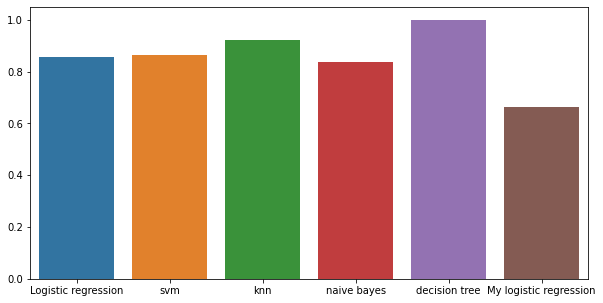

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
models = [LogisticRegression(), KNeighborsClassifier(), SVC(), GaussianNB(), DecisionTreeClassifier(), MyLogReg()]
models_name = ['Logistic regression', 'svm', 'knn', 'naive bayes', 'decision tree', 'My logistic regression']
accuracies_ = []
for i in range(len(models)):
    models[i].fit(X_train, y_train)
    accuracies_.append(accuracy_score(y_test, models[i].predict(X_test)))
data = {
    'Model': models_name,
    'Accuracy on test': accuracies_, 
    #'Best Params': best_models_params,
}
frame = pd.DataFrame(data = data)
print(frame.sort_values(by="Accuracy on test"))
sns.barplot(x=models_name, y=accuracies)
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Выполним подбор гиперпараметров моделей и кросс-валидацию на обучающей выборке:

In [25]:

models = [LogisticRegression(), KNeighborsClassifier(), SVC(), GaussianNB(), DecisionTreeClassifier()]
models_name = ['Logistic regression', 'svm', 'knn', 'naive bayes', 'decision tree']
max_name_len = max([len(i) for i in models_name])
models_params = [{'C': np.linspace(0.1**3, 3, math.floor(3/0.1))},
                 {'n_neighbors': range (3, 8), 'weights': ['uniform', 'distance'], 'p':[1, 2]},
                 {'C': np.linspace(0.1**3, 3, math.floor(3/0.1)), 'kernel':['linear', 'poly', 'rbf','sigmoid'], "degree":range(1, 6), 'gamma':['scale', 'auto']},
                 {'var_smoothing': np.logspace(0,-9, num=100)},
                 {"criterion": ['gini', 'entropy', 'log_loss'], "splitter": ['best', 'random'], 'class_weight':[None, 'balanced']}
                ]
best_models_params = []
accuracies = []
confusion_matrices = []
print("Best model's parameters:")
for i in range(len(models)):
    searcher = GridSearchCV(models[i], param_grid = models_params[i], scoring="accuracy", refit="accuracy")
    searcher.fit(X_train, y_train)
    prediction = searcher.predict(X_test)
    accuracies.append(accuracy_score(y_test, prediction))
    confusion_matrices.append(confusion_matrix(y_test, prediction))
    best_models_params.append(searcher.best_params_)
    print(models_name[i].ljust(max_name_len) + ": " + str(best_models_params[-1]))

model = MyLogReg()
searcher = MyGridSearcher(model, X_train, y_train, np.linspace(0.1**3, 3, math.floor(3/0.1)), np.linspace(0.1**3, 3, math.floor(3/0.1)), accuracy_score)
my_best_params = searcher.search()
best_models_params.append({'alph':my_best_params[0], 'conf':my_best_params[1]})
my_pred = model.predict(X_test)
accuracies.append(accuracy_score(my_pred, y_test))
confusion_matrices.append(confusion_matrix(y_test, my_pred))
models_name.append("My Logistic regression")
print(models_name[-1].ljust(max_name_len) + ": " + str(best_models_params[-1]))

Best model's parameters:
Logistic regression: {'C': 2.586344827586207}
svm                : {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
knn                : {'C': 2.7931724137931035, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}
naive bayes        : {'var_smoothing': 0.04328761281083057}
decision tree      : {'class_weight': None, 'criterion': 'entropy', 'splitter': 'random'}
My Logistic regression: {'alph': 0.20782758620689656, 'conf': 0.5180689655172414}


Посмотрим на точность моделей на тестовой выборке после подбора гиперпараметров и кросс-валидации:

                    Model  Accuracy on test  Accuracy delta
5  My Logistic regression          0.814634        0.151220
3             naive bayes          0.853659        0.014634
0     Logistic regression          0.878049        0.019512
1                     svm          1.000000        0.136585
2                     knn          1.000000        0.078049
4           decision tree          1.000000        0.000000


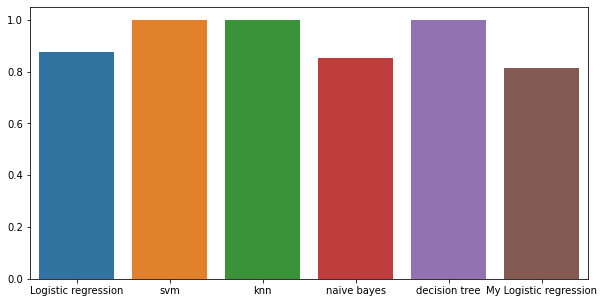

In [26]:
data = {
    'Model': models_name,
    'Accuracy on test': accuracies, 
    #'Best Params': best_models_params,
    'Accuracy delta': [math.fabs(i[0]-i[1]) for i in list(zip(accuracies, accuracies_))]
}
frame = pd.DataFrame(data = data)
print(frame.sort_values(by="Accuracy on test"))
sns.barplot(x=models_name, y=accuracies)
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()


Точность моделей заметно повысилась. Некоторые модели вообще не ошибаются на тестовой выборке.

Построим матрицы ошибок:

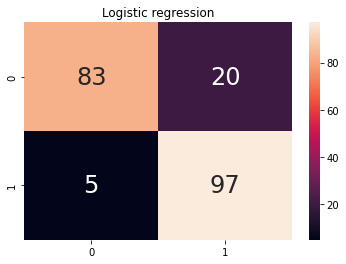

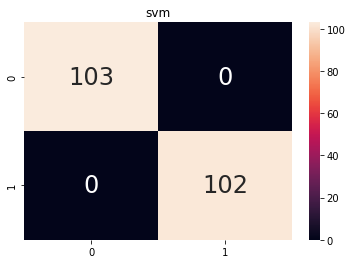

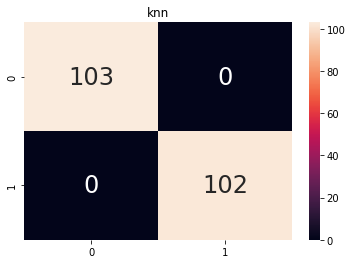

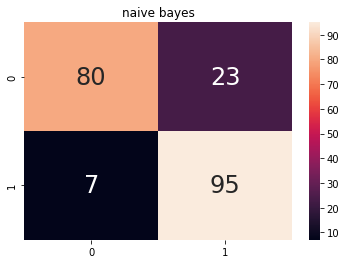

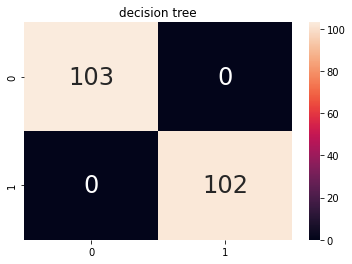

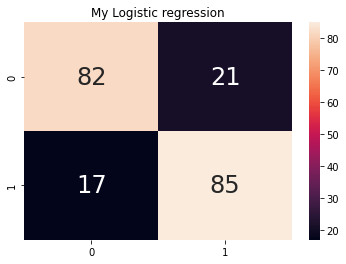

In [27]:
for i in range(len(confusion_matrices)):
    sns.heatmap(confusion_matrices[i], annot=True,cbar=True, fmt='d', annot_kws={"size": 24})
    plt.title(label=models_name[i])
    plt.show()



В ходе исследования точности работы моделей было выявлены следующие закономерности:
1. decision tree показала себя лучше всех, она не ошибается при классификации. 
2. knn уступает decision tree, однако после подбора гиперпараметров и кросс-валидации она перестала ошибаться в своих предсказаниях
3. svm существенно улучшила свои предсказания после подбора гиперпараметров и кросс-валидации и стала работать безошибочно на тестовой выборке
4. naive bayes, logistic regression и реализованная модель логистической регрессии показывают схожую точность после подбора гиперапараметров. Однако, хочется заметить, что реализованная модель логистической регрессии получила наибольший прирост точности предсказаний.